This post discusses and shows the impact of the `useRandomCoords` option for the RDKit's conformer generator.

The RDKit's conformation generator is based on distance geometry. Here are the basic steps for the standard approach:

1. The molecule's distance bounds matrix is calculated based on the connection table and a set of rules.
2. The bounds matrix is smoothed using a triangle-bounds smoothing algorithm.
3. A random distance matrix that satisfies the bounds matrix is generated.
4. This distance matrix is embedded in 3 or 4 dimensions (producing coordinates for each atom).
5. The resulting coordinates are cleaned up somewhat using a crude force field (the "distance geometry force field") and the bounds matrix.
6. If 4D embedding was done: another minimization is done with the distance geometry force field including a term to drive the 4th coordinate to zero.
7. If either experimental torsions (ET) or basic knowledge terms (K) are being used (the default is to use both because the conformations are higher quality), a final minimization is done using the "ET", "K", or "ETK" force fields. 

Another way to generate the initial set of coordinates is to replace steps 3 and 4 with just picking a set of random coordinates (i.e. scatter the atoms randomly about a 3D box) and then moving on to step 5 and minimizing those using the distance geometry force field mentioned above. I learned of this approach from David Spellmeyer, who published it back in 1997: https://doi.org/10.1016/S1093-3263(97)00014-4

Starting from random coordinates has been possible within the RDKit more or less since the beginning (I've known David a long time ;-), but it's not the default because my implementation of it was slower than the standard embedding approach in the early testing and validation work I did. I've been saying for years that random-coordinate embedding is more robust (though slower), but I haven't actually gone back and tested/quantified that since my initial experiments. This blog post aims to clear some of that up.

TL;DR: I ran some experiments using a set of 900 molecules with varying numbers of rotatable bonds and two different macrocycle sizes. Each molecule has at least two specified stereocenters. Given the current implementation, random-coordinate embedding is more robust - it's more likely to produce the requested number of conformers for these structures than the standard metric embedding is - but it still tends to be a bit slower.

Here's a graphical summary of the results:
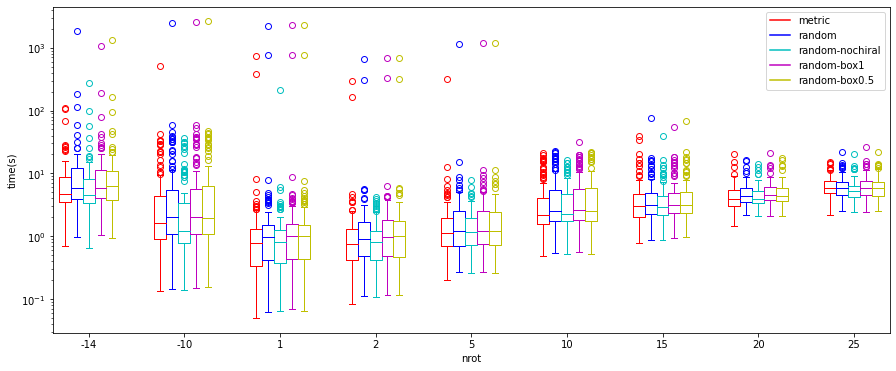
The main conclusion about timing can be see by comparing the red (metric) and blue (random) data.

Here's a plot comparing how long it takes to generate each conformer when trying for 50 conformers (left) or 50 more diverse conformers (right), the plot has been zoomed in, so a few extreme outliers (which impact the standard metric embedding more severely than the random-coordinate embedding) are not visible.

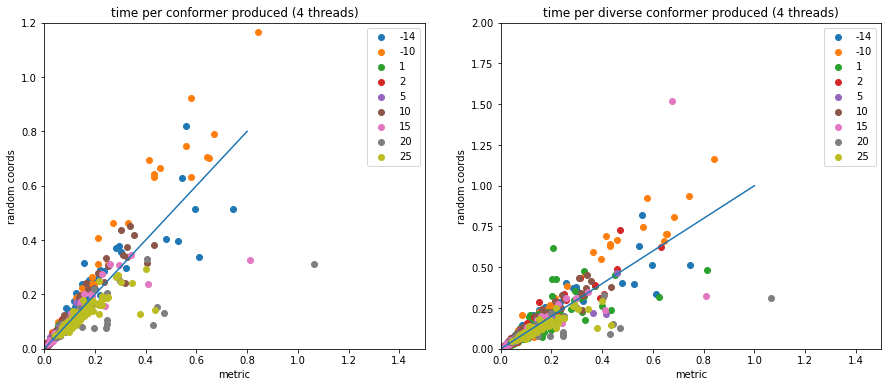

Given that it is certainly more robust and that the overall performance difference isn't huge, I think I'm likely to switch to using random-coordinate embedding for my future work. Maybe we can think about making it the default in the RDKit too.

For those who are interested, here's the original literature about ETKDG:
- The original ETKDG publication: https://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
- Sereina Riniker's presentation at the 2015 RDKit UGM: https://github.com/rdkit/UGM_2015/blob/master/Presentations/ETKDG.SereinaRiniker.pdf
- An update describing ETKDGv3 and extensions to better handle small rings and macrocycles: https://pubs.acs.org/doi/abs/10.1021/acs.jcim.0c00025

If you want to play with the compounds yourself, the SMILES are all in the [rdkit_blog github repo]()


Ok, let's get to work and generate the data.

In [147]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import pandas as pd
import rdkit
print(rdkit.__version__)
%load_ext sql
%pylab inline

2020.09.4
The sql extension is already loaded. To reload it, use:
  %reload_ext sql
Populating the interactive namespace from numpy and matplotlib


# Collecting test molecules from ChEMBL

For this exercise I want a set of molecules which have varying numbers of rotatable bonds and which include at least two specified chiral centers. I include the constraint on chiral centers because the RDKit's conformation generator normally only returns conformations which match the specified stereochemistry. This can make conformation generation slower and I'm curious to see the impact of that as part of this post.

Start with a few queries against my local copy of ChEMBL27 to see how many molecules with at least two specified chiral centers are available with different numbers of rotatable bonds:

In [2]:
%sql postgresql://localhost/chembl_27 \
    select count(*) from compound_properties \
    join compound_structures using (molregno) \
    where rtb = 2 and \
    array_length(regexp_split_to_array(canonical_smiles,'@+'),1)-1 >2;

1 rows affected.


count
14904


In [3]:
%sql postgresql://localhost/chembl_27 \
    select count(*) from compound_properties \
    join compound_structures using (molregno) \
    where rtb = 5 and \
    array_length(regexp_split_to_array(canonical_smiles,'@+'),1)-1 >2;

1 rows affected.


count
20586


In [4]:
%sql postgresql://localhost/chembl_27 \
    select count(*) from compound_properties \
    join compound_structures using (molregno) \
    where rtb = 10 and \
    array_length(regexp_split_to_array(canonical_smiles,'@+'),1)-1 >2;

1 rows affected.


count
9845


In [5]:
%sql postgresql://localhost/chembl_27 \
    select count(*) from compound_properties \
    join compound_structures using (molregno) \
    where rtb = 15 and \
    array_length(regexp_split_to_array(canonical_smiles,'@+'),1)-1 >2;

1 rows affected.


count
3834


In [6]:
%sql postgresql://localhost/chembl_27 \
    select count(*) from compound_properties \
    join compound_structures using (molregno) \
    where rtb = 25 and \
    array_length(regexp_split_to_array(canonical_smiles,'@+'),1)-1 >2;

1 rows affected.


count
1129


Looks like we can get plenty of molecules with up to 25 rotatable bonds, so let's go ahead and collect a set of 100 molecules for each of the rotatable bond counts 1, 2, 5, 10, 15, 20, and 15. I also include two additional sets of 100 molecules: one which contains at least one ring of size 10 and one which contains at least one ring of size 14. These macrocycles show up in what comes below with negative numbers of rotatable bonds: -10 for the compounds with a 10-ring and -14 for compounds with a 14-ring.

In [24]:
overall_data = []
for tgt in (1,2,5,10,15,20,25):
    d = %sql postgresql://localhost/chembl_27 \
      select * from (select canonical_smiles,chembl_id,rtb from compound_properties \
      join compound_structures using (molregno) \
      join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
      where rtb = :tgt and \
      mw_freebase = full_mwt and \
      array_length(regexp_split_to_array(canonical_smiles,'@+'),1)-1 >2) tmp \
      order by random() \
      limit 100;
    overall_data.extend(d)
for tgt in (10,14):
    sma = f'[r{tgt}]'
    d = %sql postgresql://localhost/chembl_27 \
      select * from (select canonical_smiles,chembl_id,-1 * :tgt from compound_properties \
      join compound_structures using (molregno) \
      join rdk.mols using (molregno) \
      join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
      where m@>:sma ::qmol and \
      mw_freebase = full_mwt and \
      array_length(regexp_split_to_array(canonical_smiles,'@+'),1)-1 >2) tmp \
      order by random() \
      limit 100;
    overall_data.extend(d)

with open('../data/chembl27_confgen_tgts.txt','w+') as outf:
    outf.write('SMILES CHEMBL_ID RTB\n')
    for line in overall_data:
        outf.write(' '.join(str(x) for x in line)+'\n')

100 rows affected.
100 rows affected.
100 rows affected.
100 rows affected.
100 rows affected.
100 rows affected.
100 rows affected.
100 rows affected.
100 rows affected.


In [25]:
!head ../data/chembl27_confgen_tgts.txt

SMILES CHEMBL_ID RTB
C[C@@H]1C[C@@]2(C)[C@@H](CC[C@H]3[C@@H]4CC[C@H](O)[C@@]4(C)CC[C@@H]32)C/C1=N\N=C1/C[C@@H]2CC[C@H]3[C@@H]4CC[C@H](O)[C@@]4(C)CC[C@@H]3[C@@]2(C)C[C@H]1C CHEMBL2104408 1
CC(C)[C@@H]1OC(=O)C2(/C=C/c3ccc4ccc(nc4c3)[C@@H](C)NC(=O)[C@@H]3CCCN(N3)C(=O)[C@H](C)NC1=O)CCS(=O)(=O)CC2 CHEMBL4175329 1
CC(=O)O[C@H]1CCC[C@@H]2COC(=O)[C@@H]21 CHEMBL2228334 1
CNC(=O)O[C@H]1OC(=O)[C@H]2[C@H]3C=C[C@H](C3)[C@H]21 CHEMBL3989617 1
CC1(C)CC[C@]2(C)CC[C@]3(C(=O)O)C(=CC[C@@H]4[C@@]5(C)CC[C@H](O)C(C)(C)[C@@H]5CC[C@]43C)[C@@H]2C1 CHEMBL559587 1
CC1(C)[C@@H](O)CC[C@]2(C)C3=C(CC[C@@H]12)[C@@]1(C)CC[C@@]2(C)CC[C@@](C)(CO)C[C@H]2[C@]1(C)CC3 CHEMBL484238 1
C[C@]12CC[C@H](c3cc(F)c(O)cc3F)C[C@H]1CC[C@@H]2O CHEMBL1651144 1
Cc1cncc(C2=CC=C3[C@@H]4CCC5CNC(=O)CC[C@]5(C)[C@H]4CC[C@]23C)c1 CHEMBL3938064 1
C[C@H](O)[C@H]1O[C@@H]2SC(N3CCCC3)=N[C@@H]2[C@@H](O)[C@@H]1O CHEMBL3647379 1


# Run the experiments

Now we read those molecules back in and then start collecting data.

Here are the different experiments:

1. Generate a single conformer for each molecule.
2. Try to generate 50 conformers for each molecule.
3. Try to generate 50 diverse conformers for each molecule using an RMSD filter of 0.5
4. Try to generate 50 conformers for each molecule ignoring stereochemistry

We will use ETKDGv3 and repeat each run once starting from standard embedding and once starting from random coordinates.


In [26]:
suppl = Chem.SmilesMolSupplier('../data/chembl27_confgen_tgts.txt')
ms = [Chem.AddHs(m) for m in suppl]

In [27]:
from rdkit.Chem import AllChem
from collections import defaultdict
import time
import pickle

## Single conformer

In [28]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
metric_etkdg_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMolecule(m,ps)
    t2 = time.time()
    metric_etkdg_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [08:35:54] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [08:37:03] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [08:37:18] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


In [29]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
ps.useRandomCoords = True
random_etkdg_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMolecule(m,ps)
    t2 = time.time()
    random_etkdg_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,random_etkdg_res,),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [08:45:08] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [08:47:42] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [08:47:59] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


## 50 conformers

In [30]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
ps.numThreads = 4
metric_etkdg50_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMultipleConfs(m,50,ps)
    t2 = time.time()
    metric_etkdg50_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,random_etkdg_res,metric_etkdg50_res,),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [09:18:45] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [09:35:11] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [09:38:47] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


In [31]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
ps.numThreads = 4
ps.useRandomCoords = True
random_etkdg50_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMultipleConfs(m,50,ps)
    t2 = time.time()
    random_etkdg50_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,random_etkdg_res,metric_etkdg50_res,random_etkdg50_res,),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [11:36:31] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [12:14:02] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [12:18:03] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


# Include RMS Pruning

In [32]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
ps.numThreads = 4
ps.pruneRmsThresh = 0.5
metric_etkdg50_rms_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMultipleConfs(m,50,ps)
    t2 = time.time()
    metric_etkdg50_rms_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,random_etkdg_res,metric_etkdg50_res,random_etkdg50_res,
                 metric_etkdg50_rms_res,),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [14:52:33] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [15:09:11] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [15:12:48] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


In [33]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
ps.numThreads = 4
ps.useRandomCoords = True
ps.pruneRmsThresh = 0.5

random_etkdg50_rms_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMultipleConfs(m,50,ps)
    t2 = time.time()
    random_etkdg50_rms_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,random_etkdg_res,metric_etkdg50_res,random_etkdg50_res,
                 metric_etkdg50_rms_res,random_etkdg50_rms_res),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [17:11:32] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [17:49:30] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [17:53:32] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


In [34]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
ps.numThreads = 4
ps.enforceChirality = False
metric_etkdg50_nochiral_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMultipleConfs(m,50,ps)
    t2 = time.time()
    metric_etkdg50_nochiral_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,random_etkdg_res,metric_etkdg50_res,random_etkdg50_res,
                 metric_etkdg50_rms_res,random_etkdg50_rms_res,metric_etkdg50_nochiral_res,),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [20:08:24] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [20:13:33] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [20:16:14] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


In [35]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
ps.numThreads = 4
ps.useRandomCoords = True
ps.enforceChirality = False

random_etkdg50_nochiral_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMultipleConfs(m,50,ps)
    t2 = time.time()
    random_etkdg50_nochiral_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,random_etkdg_res,metric_etkdg50_res,random_etkdg50_res,
                 metric_etkdg50_rms_res,random_etkdg50_rms_res,metric_etkdg50_nochiral_res,
                 random_etkdg50_nochiral_res),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [21:03:45] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [21:09:44] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [21:12:47] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


In [36]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
ps.numThreads = 4
ps.useRandomCoords = True
ps.boxSizeMult = 1.0

random_etkdg50_box1_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMultipleConfs(m,50,ps)
    t2 = time.time()
    random_etkdg50_box1_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,random_etkdg_res,metric_etkdg50_res,random_etkdg50_res,
                 metric_etkdg50_rms_res,random_etkdg50_rms_res,metric_etkdg50_nochiral_res,
                 random_etkdg50_nochiral_res, random_etkdg50_box1_res),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [23:01:32] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [23:40:42] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [23:44:42] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


In [37]:
ps = AllChem.ETKDGv3()
ps.randomSeed=0xf00d
ps.numThreads = 4
ps.useRandomCoords = True
ps.boxSizeMult = 0.5

random_etkdg50_box2_res = []
for i,m in enumerate(ms):
    if not (i+1)%10:
        print(f'Doing {i+1} of {len(ms)}')
    m = Chem.Mol(m)
    t1 = time.time()
    AllChem.EmbedMultipleConfs(m,50,ps)
    t2 = time.time()
    random_etkdg50_box2_res.append((t2-t1,m.GetNumConformers(),m,m.GetIntProp('RTB')))
with open('./results/random_coords_expt.pkl','wb+') as outf:
    pickle.dump((metric_etkdg_res,random_etkdg_res,metric_etkdg50_res,random_etkdg50_res,
                 metric_etkdg50_rms_res,random_etkdg50_rms_res,metric_etkdg50_nochiral_res,
                 random_etkdg50_nochiral_res, random_etkdg50_box1_res, random_etkdg50_box2_res),outf)

Doing 10 of 900
Doing 20 of 900
Doing 30 of 900
Doing 40 of 900
Doing 50 of 900
Doing 60 of 900
Doing 70 of 900
Doing 80 of 900
Doing 90 of 900
Doing 100 of 900
Doing 110 of 900
Doing 120 of 900
Doing 130 of 900
Doing 140 of 900


RDKit ERROR: [02:43:34] UFFTYPER: Unrecognized charge state for atom: 10


Doing 150 of 900
Doing 160 of 900
Doing 170 of 900
Doing 180 of 900
Doing 190 of 900
Doing 200 of 900
Doing 210 of 900
Doing 220 of 900
Doing 230 of 900
Doing 240 of 900
Doing 250 of 900
Doing 260 of 900
Doing 270 of 900
Doing 280 of 900
Doing 290 of 900
Doing 300 of 900
Doing 310 of 900
Doing 320 of 900
Doing 330 of 900
Doing 340 of 900


RDKit ERROR: [03:22:12] UFFTYPER: Unrecognized charge state for atom: 11


Doing 350 of 900
Doing 360 of 900
Doing 370 of 900
Doing 380 of 900


RDKit ERROR: [03:26:06] UFFTYPER: Unrecognized charge state for atom: 9


Doing 390 of 900
Doing 400 of 900
Doing 410 of 900
Doing 420 of 900
Doing 430 of 900
Doing 440 of 900
Doing 450 of 900
Doing 460 of 900
Doing 470 of 900
Doing 480 of 900
Doing 490 of 900
Doing 500 of 900
Doing 510 of 900
Doing 520 of 900
Doing 530 of 900
Doing 540 of 900
Doing 550 of 900
Doing 560 of 900
Doing 570 of 900
Doing 580 of 900
Doing 590 of 900
Doing 600 of 900
Doing 610 of 900
Doing 620 of 900
Doing 630 of 900
Doing 640 of 900
Doing 650 of 900
Doing 660 of 900
Doing 670 of 900
Doing 680 of 900
Doing 690 of 900
Doing 700 of 900
Doing 710 of 900
Doing 720 of 900
Doing 730 of 900
Doing 740 of 900
Doing 750 of 900
Doing 760 of 900
Doing 770 of 900
Doing 780 of 900
Doing 790 of 900
Doing 800 of 900
Doing 810 of 900
Doing 820 of 900
Doing 830 of 900
Doing 840 of 900
Doing 850 of 900
Doing 860 of 900
Doing 870 of 900
Doing 880 of 900
Doing 890 of 900
Doing 900 of 900


# Do the Analysis

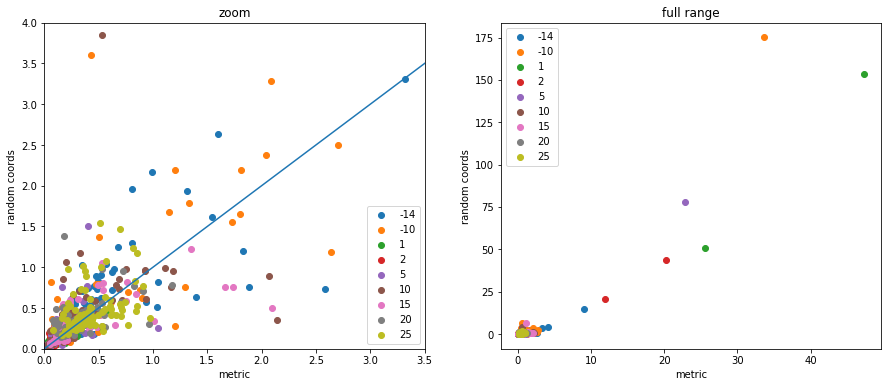

In [170]:
figsize(15,6)

nrots = sorted(set(x[-1] for x in metric_etkdg_res))

subplot(1,2,1)
for nrot in nrots:
    xp = [x[0] for x in metric_etkdg_res if x[-1]==nrot]
    yp = [x[0] for x in random_etkdg_res if x[-1]==nrot]
    scatter(xp,yp,label=str(nrot))
legend();
xlim(0,3.5);
ylim(0,4);
plot((0,4),(0,4))
xlabel('metric')
ylabel('random coords');
title('zoom');

subplot(1,2,2)
for nrot in nrots:
    xp = [x[0] for x in metric_etkdg_res if x[-1]==nrot]
    yp = [x[0] for x in random_etkdg_res if x[-1]==nrot]
    scatter(xp,yp,label=str(nrot))
legend();
xlabel('metric')
ylabel('random coords');
title('full range');

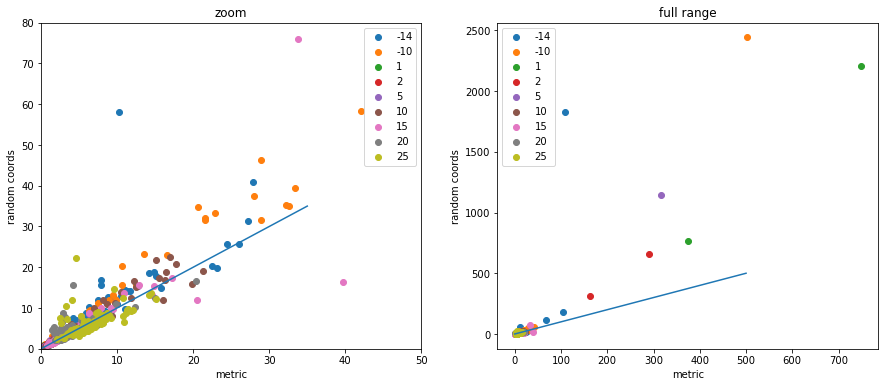

In [171]:
figsize(15,6)
nrots = sorted(set(x[-1] for x in metric_etkdg_res))

subplot(1,2,1)
for nrot in nrots:
    xp = [x[0] for x in metric_etkdg50_res if x[-1]==nrot]
    yp = [x[0] for x in random_etkdg50_res if x[-1]==nrot]
    scatter(xp,yp,label=str(nrot))
legend();
xlim(0,50);
ylim(0,80);
plot((0,35),(0,35))
title('time (s)')
xlabel('metric')
ylabel('random coords');
title('zoom');

subplot(1,2,2)
for nrot in nrots:
    xp = [x[0] for x in metric_etkdg50_res if x[-1]==nrot]
    yp = [x[0] for x in random_etkdg50_res if x[-1]==nrot]
    scatter(xp,yp,label=str(nrot))
legend();
#xlim(0,25);
#ylim(0,35);
plot((0,500),(0,500))
title('time (s)')
xlabel('metric')
ylabel('random coords');
title('full range');

number of mols with below 50 conformers:
  -14 rotatable bonds, metric: 8 random: 0
  -10 rotatable bonds, metric: 1 random: 1
  1 rotatable bonds, metric: 2 random: 2
  2 rotatable bonds, metric: 2 random: 2
  5 rotatable bonds, metric: 1 random: 1
  10 rotatable bonds, metric: 4 random: 0
  15 rotatable bonds, metric: 10 random: 0
  20 rotatable bonds, metric: 27 random: 0
  25 rotatable bonds, metric: 28 random: 0


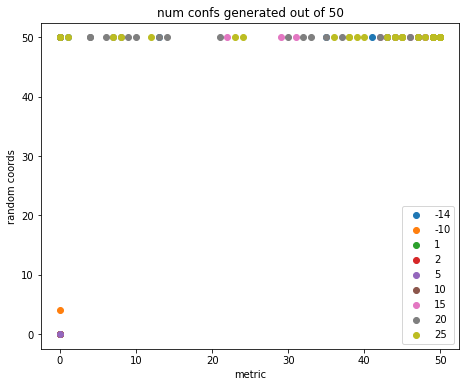

In [54]:
figsize(7.5,6)
nrots = sorted(set(x[-1] for x in metric_etkdg_res))
print(f'number of mols with below 50 conformers:')
for nrot in nrots:
    xp = [x[1] for x in metric_etkdg50_res if x[-1]==nrot]
    yp = [x[1] for x in random_etkdg50_res if x[-1]==nrot]
    print(f'  {nrot} rotatable bonds, metric: {len([1 for x in xp if x!=50])} random: {len([1 for x in yp if x!=50])}')
    scatter(xp,yp,label=str(nrot))
legend();
#xlim(0,30);
#ylim(0,40);
#plot((0,30),(0,30))
title('num confs generated out of 50')
xlabel('metric')
ylabel('random coords');

number of mols with below 50 conformers:
  -14 rotatable bonds, metric: 31 random: 17
  -10 rotatable bonds, metric: 85 random: 83
  1 rotatable bonds, metric: 99 random: 99
  2 rotatable bonds, metric: 100 random: 100
  5 rotatable bonds, metric: 93 random: 85
  10 rotatable bonds, metric: 32 random: 19
  15 rotatable bonds, metric: 13 random: 1
  20 rotatable bonds, metric: 27 random: 0
  25 rotatable bonds, metric: 28 random: 0


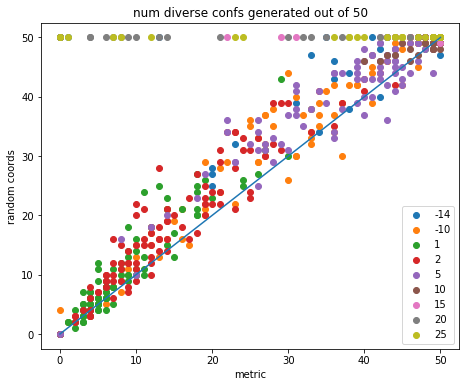

In [55]:
figsize(7.5,6)
nrots = sorted(set(x[-1] for x in metric_etkdg_res))
print(f'number of mols with below 50 conformers:')
for nrot in nrots:
    xp = [x[1] for x in metric_etkdg50_rms_res if x[-1]==nrot]
    yp = [x[1] for x in random_etkdg50_rms_res if x[-1]==nrot]
    print(f'  {nrot} rotatable bonds, metric: {len([1 for x in xp if x!=50])} random: {len([1 for x in yp if x!=50])}')
    scatter(xp,yp,label=str(nrot))
legend();
#xlim(0,30);
#ylim(0,40);
plot((0,50),(0,50))
title('num diverse confs generated out of 50')
xlabel('metric')
ylabel('random coords');

number of mols with below 50 conformers:
  -14 rotatable bonds, metric: 6 random: 0
  -10 rotatable bonds, metric: 0 random: 0
  1 rotatable bonds, metric: 0 random: 0
  2 rotatable bonds, metric: 0 random: 0
  5 rotatable bonds, metric: 0 random: 0
  10 rotatable bonds, metric: 2 random: 0
  15 rotatable bonds, metric: 9 random: 0
  20 rotatable bonds, metric: 26 random: 0
  25 rotatable bonds, metric: 21 random: 0


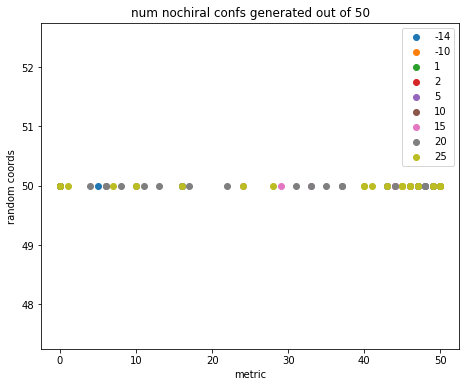

In [56]:
figsize(7.5,6)
nrots = sorted(set(x[-1] for x in metric_etkdg_res))
print(f'number of mols with below 50 conformers:')
for nrot in nrots:
    xp = [x[1] for x in metric_etkdg50_nochiral_res if x[-1]==nrot]
    yp = [x[1] for x in random_etkdg50_nochiral_res if x[-1]==nrot]
    print(f'  {nrot} rotatable bonds, metric: {len([1 for x in xp if x!=50])} random: {len([1 for x in yp if x!=50])}')
    scatter(xp,yp,label=str(nrot))
legend();
#xlim(0,30);
#ylim(0,40);
#plot((0,30),(0,30))
title('num nochiral confs generated out of 50')
xlabel('metric')
ylabel('random coords');


The random coordinate embedding produces 50 conformers in almost every case, while there are a significant number of examples where metric embedding is unable to produce all 50 conformers.

## Time per conformer generated

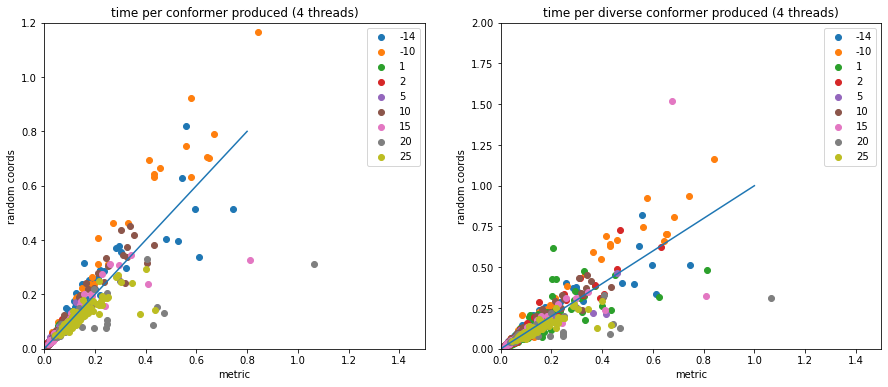

In [62]:
figsize(15,6)
nrots = sorted(set(x[-1] for x in metric_etkdg_res))

subplot(1,2,1)
for nrot in nrots:
    keep = [i for i,(x,y) in enumerate(zip(metric_etkdg50_res,random_etkdg50_res)) if x[-1]==nrot and x[1]!=0 and y[1]!=0]
    xp = [metric_etkdg50_res[x][0]/metric_etkdg50_res[x][1] for x in keep]
    yp = [random_etkdg50_res[x][0]/random_etkdg50_res[x][1] for x in keep]
    scatter(xp,yp,label=str(nrot))
legend();
xlim(0,1.5);
ylim(0,1.2);
plot((0,.8),(0,.8))
title('time per conformer produced (4 threads)')
xlabel('metric')
ylabel('random coords');

subplot(1,2,2)
for nrot in nrots:
    keep = [i for i,(x,y) in enumerate(zip(metric_etkdg50_rms_res,random_etkdg50_rms_res)) if x[-1]==nrot and x[1]!=0 and y[1]!=0]
    xp = [metric_etkdg50_res[x][0]/metric_etkdg50_rms_res[x][1] for x in keep]
    yp = [random_etkdg50_res[x][0]/random_etkdg50_rms_res[x][1] for x in keep]
    scatter(xp,yp,label=str(nrot))
legend();
xlim(0,1.5);
ylim(0,2);
plot((0,1),(0,1))
title('time per diverse conformer produced (4 threads)')
xlabel('metric')
ylabel('random coords');


Look at the same thing without cropping outliers.

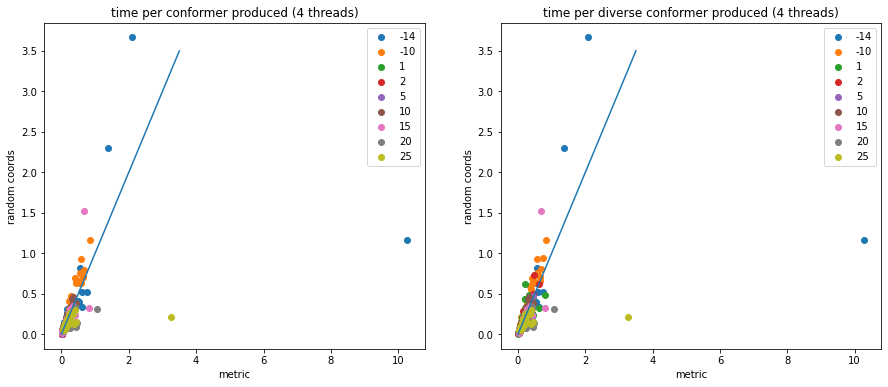

In [173]:
figsize(15,6)
nrots = sorted(set(x[-1] for x in metric_etkdg_res))

subplot(1,2,1)
for nrot in nrots:
    keep = [i for i,(x,y) in enumerate(zip(metric_etkdg50_res,random_etkdg50_res)) if x[-1]==nrot and x[1]!=0 and y[1]!=0]
    xp = [metric_etkdg50_res[x][0]/metric_etkdg50_res[x][1] for x in keep]
    yp = [random_etkdg50_res[x][0]/random_etkdg50_res[x][1] for x in keep]
    scatter(xp,yp,label=str(nrot))
legend();
plot((0,3.5),(0,3.5))
title('time per conformer produced (4 threads)')
xlabel('metric')
ylabel('random coords');

subplot(1,2,2)
for nrot in nrots:
    keep = [i for i,(x,y) in enumerate(zip(metric_etkdg50_rms_res,random_etkdg50_rms_res)) if x[-1]==nrot and x[1]!=0 and y[1]!=0]
    xp = [metric_etkdg50_res[x][0]/metric_etkdg50_rms_res[x][1] for x in keep]
    yp = [random_etkdg50_res[x][0]/random_etkdg50_rms_res[x][1] for x in keep]
    scatter(xp,yp,label=str(nrot))
legend();
plot((0,3.5),(0,3.5))
title('time per diverse conformer produced (4 threads)')
xlabel('metric')
ylabel('random coords');


Note that these times per conformer cannot be directly compared to the time to generate a single conformer since these were run using multiple threads.

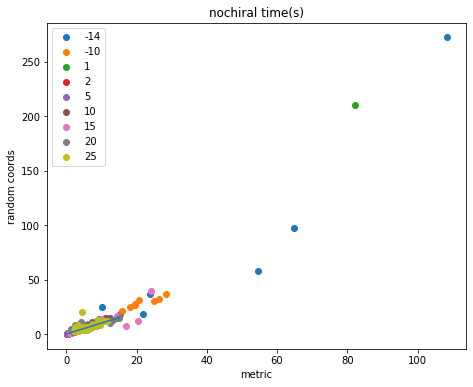

In [63]:
figsize(7.5,6)
nrots = sorted(set(x[-1] for x in metric_etkdg_res))
for nrot in nrots:
    xp = [x[0] for x in metric_etkdg50_nochiral_res if x[-1]==nrot]
    yp = [x[0] for x in random_etkdg50_nochiral_res if x[-1]==nrot]
    scatter(xp,yp,label=str(nrot))
legend();
#xlim(0,30);
#ylim(0,40);
plot((0,15),(0,15))
title('nochiral time(s)')
xlabel('metric')
ylabel('random coords');

General impact of ignoring chirality

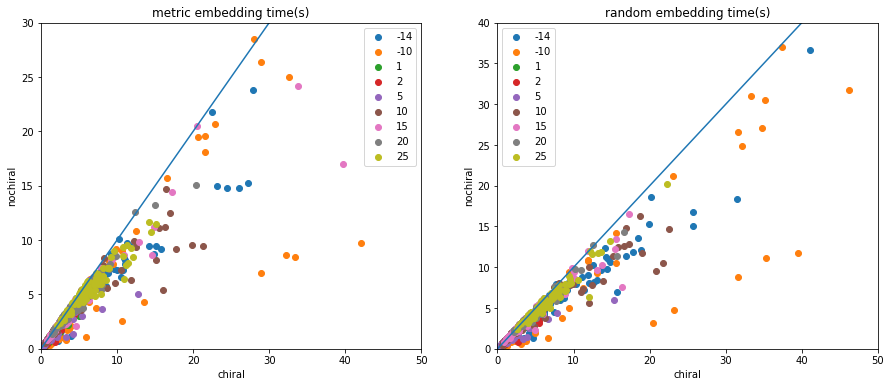

In [71]:
nrots = sorted(set(x[-1] for x in metric_etkdg_res))
figsize(15,6)
subplot(1,2,1)
for nrot in nrots:
    xp = [x[0] for x in metric_etkdg50_res if x[-1]==nrot]
    yp = [x[0] for x in metric_etkdg50_nochiral_res if x[-1]==nrot]
    scatter(xp,yp,label=str(nrot))
legend();
xlim(0,50);
ylim(0,30);
plot((0,30),(0,30))
title('metric embedding time(s)')
xlabel('chiral')
ylabel('nochiral');

subplot(1,2,2)
for nrot in nrots:
    xp = [x[0] for x in random_etkdg50_res if x[-1]==nrot]
    yp = [x[0] for x in random_etkdg50_nochiral_res if x[-1]==nrot]
    scatter(xp,yp,label=str(nrot))
legend();
xlim(0,50);
ylim(0,40);
plot((0,40),(0,40))
title('random embedding time(s)')
xlabel('chiral')
ylabel('nochiral');

Impact of box size on random embedding

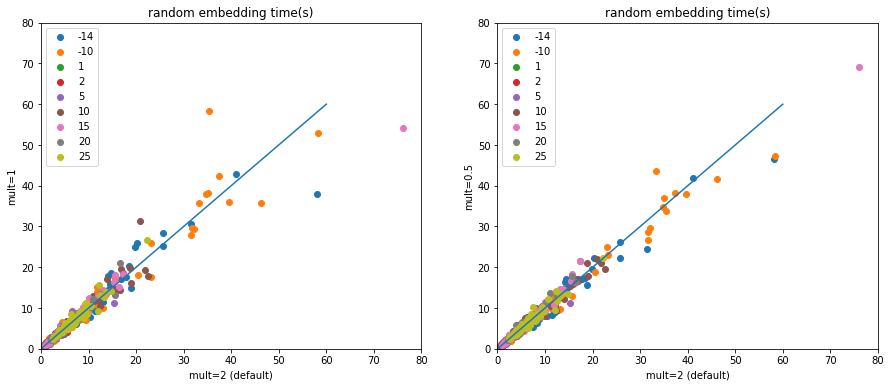

In [80]:
nrots = sorted(set(x[-1] for x in metric_etkdg_res))
figsize(15,6)
subplot(1,2,1)
for nrot in nrots:
    xp = [x[0] for x in random_etkdg50_res if x[-1]==nrot]
    yp = [x[0] for x in random_etkdg50_box1_res if x[-1]==nrot]
    scatter(xp,yp,label=str(nrot))
legend();
xlim(0,80);
ylim(0,80);
plot((0,60),(0,60))
title('random embedding time(s)')
xlabel('mult=2 (default)')
ylabel('mult=1');
    
    
subplot(1,2,2)
for nrot in nrots:
    xp = [x[0] for x in random_etkdg50_res if x[-1]==nrot]
    yp = [x[0] for x in random_etkdg50_box2_res if x[-1]==nrot]
    scatter(xp,yp,label=str(nrot))
legend();
xlim(0,80);
ylim(0,80);
plot((0,60),(0,60))
title('random embedding time(s)')
xlabel('mult=2 (default)')
ylabel('mult=0.5');
    
    

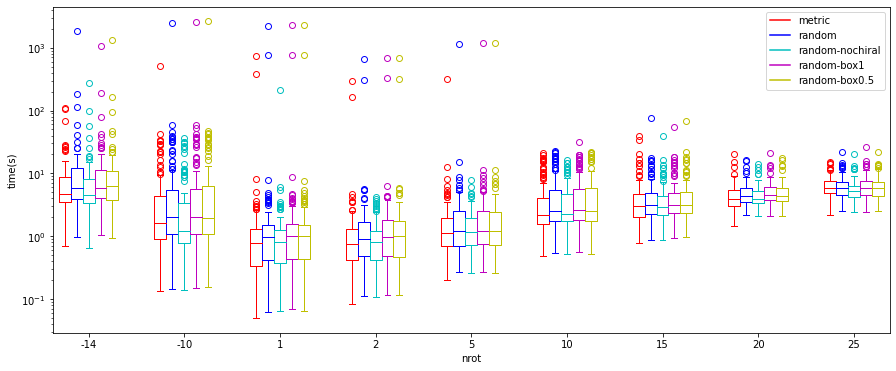

In [135]:
def set_box_color(bp, color):
    setp(bp['boxes'], color=color)
    setp(bp['whiskers'], color=color)
    setp(bp['caps'], color=color)
    setp(bp['medians'], color=color)
    setp(bp['fliers'], markeredgecolor=color)

figsize(15,6)

ax = axes()
ax.set_yscale('log');
ax.set_ylabel('time(s)')
ax.set_xlabel('nrot')

nrots = sorted(set(x[-1] for x in metric_etkdg_res))
d = [[x[0] for x in metric_etkdg50_res if x[-1]==nrot] for nrot in nrots]
bp = ax.boxplot(d,positions = [3*x for x in range(len(d))]);
set_box_color(bp,'r')

d = [[x[0] for x in random_etkdg50_res if x[-1]==nrot] for nrot in nrots]
bp = ax.boxplot(d,positions = [3*x+.5 for x in range(len(d))]);
set_box_color(bp,'b')

d = [[x[0] for x in random_etkdg50_nochiral_res if x[-1]==nrot] for nrot in nrots]
bp = ax.boxplot(d,positions = [3*x+1 for x in range(len(d))]);
set_box_color(bp,'c')

d = [[x[0] for x in random_etkdg50_box1_res if x[-1]==nrot] for nrot in nrots]
bp = ax.boxplot(d,positions = [3*x+1.5 for x in range(len(d))]);
set_box_color(bp,'m')

d = [[x[0] for x in random_etkdg50_box2_res if x[-1]==nrot] for nrot in nrots]
bp = ax.boxplot(d,positions = [3*x+2 for x in range(len(d))]);
set_box_color(bp,'y')

#set_axis_style(ax, [str(x) for x in nrots])
ticks = [str(x) for x in nrots]
xticks(np.arange(0, len(ticks) * 3, 3)+1, ticks);



plot([], c='r', label='metric')
plot([], c='b', label='random')
plot([], c='c', label='random-nochiral')
plot([], c='m', label='random-box1')
plot([], c='y', label='random-box0.5')

legend();



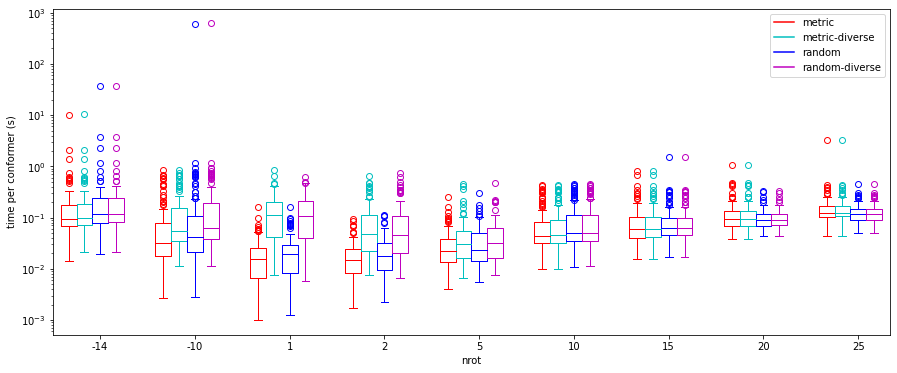

In [174]:
def set_box_color(bp, color):
    setp(bp['boxes'], color=color)
    setp(bp['whiskers'], color=color)
    setp(bp['caps'], color=color)
    setp(bp['medians'], color=color)
    setp(bp['fliers'], markeredgecolor=color)

figsize(15,6)

ax = axes()
ax.set_yscale('log');
ax.set_ylabel('time per conformer (s)')
ax.set_xlabel('nrot')

nrots = sorted(set(x[-1] for x in metric_etkdg_res))
d = [[x[0]/x[2].GetNumConformers() for x in metric_etkdg50_res if x[-1]==nrot and x[2].GetNumConformers()!=0] for nrot in nrots]
bp = ax.boxplot(d,positions = [3*x for x in range(len(d))]);
set_box_color(bp,'r')

d = [[x[0]/x[2].GetNumConformers() for x in metric_etkdg50_rms_res if x[-1]==nrot and x[2].GetNumConformers()!=0] for nrot in nrots]
bp = ax.boxplot(d,positions = [3*x+.5 for x in range(len(d))]);
set_box_color(bp,'c')

d = [[x[0]/x[2].GetNumConformers() for x in random_etkdg50_res if x[-1]==nrot and x[2].GetNumConformers()!=0] for nrot in nrots]
bp = ax.boxplot(d,positions = [3*x+1 for x in range(len(d))]);
set_box_color(bp,'b')

d = [[x[0]/x[2].GetNumConformers() for x in random_etkdg50_rms_res if x[-1]==nrot and x[2].GetNumConformers()!=0] for nrot in nrots]
bp = ax.boxplot(d,positions = [3*x+1.5 for x in range(len(d))]);
set_box_color(bp,'m')


#set_axis_style(ax, [str(x) for x in nrots])
ticks = [str(x) for x in nrots]
xticks(np.arange(0, len(ticks) * 3, 3)+1, ticks);



plot([], c='r', label='metric')
plot([], c='c', label='metric-diverse')
plot([], c='b', label='random')
plot([], c='m', label='random-diverse')

legend();




# Look at some of the troublesome structures




Which ones couldn't we generate conformers for?

In [142]:
no_confs_metric_etkdg50 = set([i for i,x in enumerate(metric_etkdg50_res) if x[2].GetNumConformers()==0])
no_confs_random_etkdg50 = set([i for i,x in enumerate(metric_etkdg50_res) if x[2].GetNumConformers()==0])
print(f'metric: {len(no_confs_metric_etkdg50)}, random embedding: {len(no_confs_random_etkdg50)}, overlap: {len(no_confs_metric_etkdg50.union(no_confs_random_etkdg50))}')

metric: 13, random embedding: 13, overlap: 13


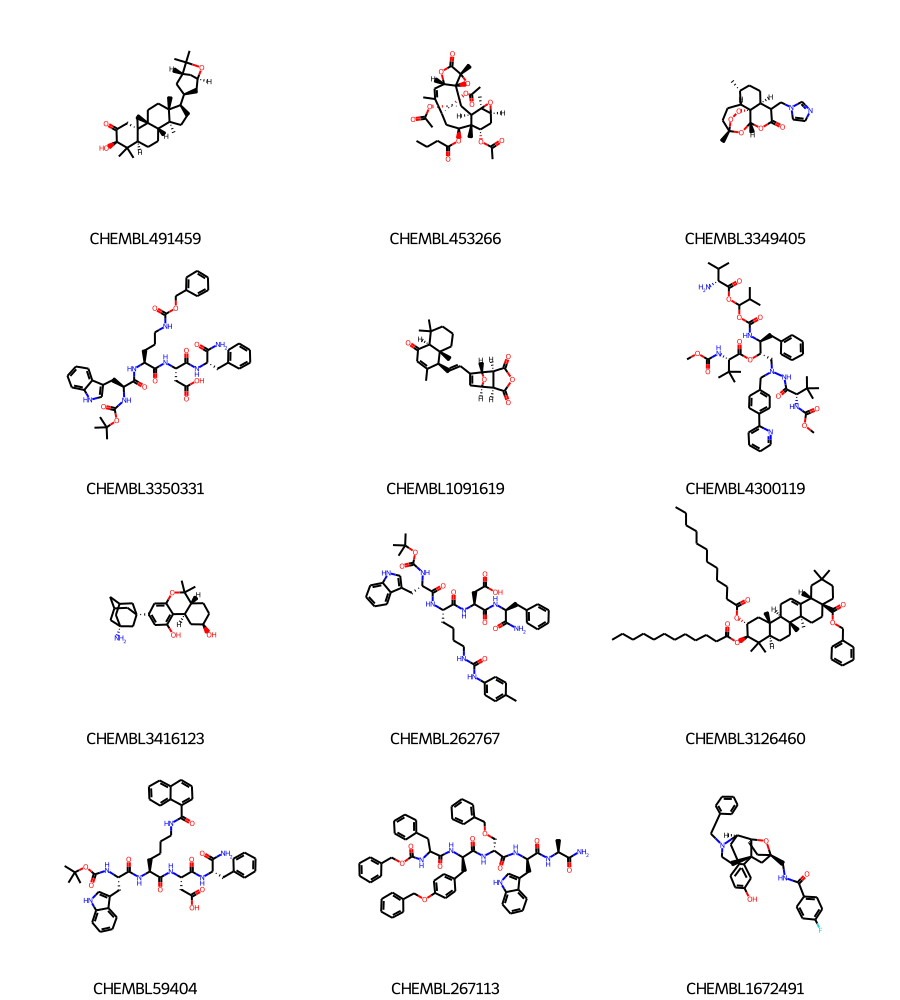

In [152]:
dms = [Chem.RemoveHs(ms[i]) for i in no_confs_metric_etkdg50]
dms = [m for m in dms if m.GetNumAtoms()<75]
Draw.MolsToGridImage(dms,subImgSize=(300,250),molsPerRow=3,
                    legends=[m.GetProp('_Name') for m in dms])

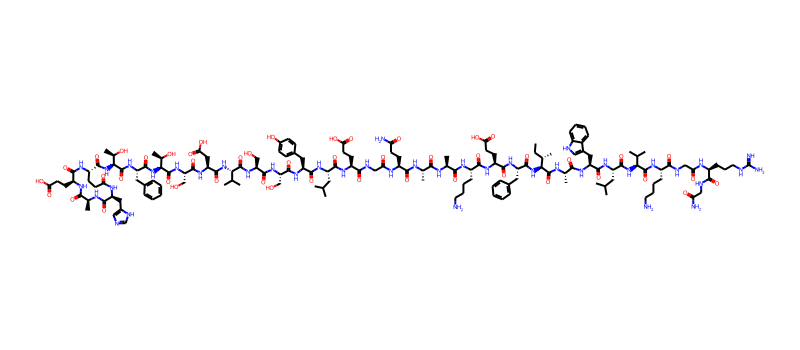

In [158]:
dms = [Chem.RemoveHs(ms[i]) for i in no_confs_metric_etkdg50]
dms = [m for m in dms if m.GetNumAtoms()>=75]
from IPython.display import SVG
d2d = Draw.MolDraw2DSVG(800,350)
d2d.DrawMolecule(dms[0])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

Ok, some of those are quite constrained and have a fair number of chiral centers, so it's easy to imagine them being hard to embed. Some (like CHEMBL59404) are just peptides though... seems like those should be manageable.
Something to look into

What about the structures which embed but take a really long time?

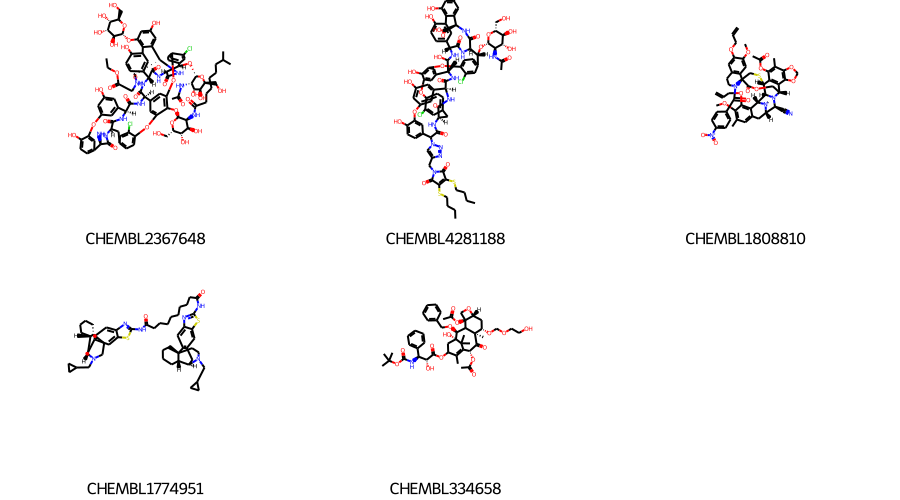

In [164]:
slow_metric_etkdg50 = [y for x,y in sorted([(x[0],i) for i,x in enumerate(metric_etkdg50_res) if x[2].GetNumConformers()],reverse=True)][:5]
dms = [Chem.RemoveHs(ms[i]) for i in slow_metric_etkdg50]
#dms = [m for m in dms if m.GetNumAtoms()<75]
Draw.MolsToGridImage(dms,subImgSize=(300,250),molsPerRow=3,
                    legends=[m.GetProp('_Name') for m in dms])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

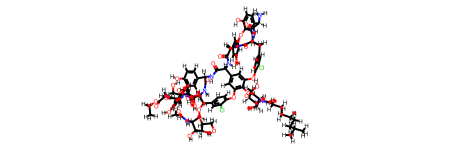

In [165]:
IPythonConsole.ipython_3d = True
metric_etkdg50_res[slow_metric_etkdg50[0]][2]

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

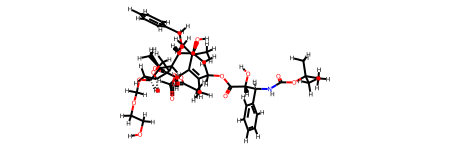

In [168]:
metric_etkdg50_res[slow_metric_etkdg50[4]][2]